In [1]:
import xarray as xr
import numpy as np

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/')))

from weather_router import isochronal_weather_router, polar, visualize


In [2]:

if not os.path.exists('cache.zarr/'):
    print('Downloading data...')
    ds = xr.open_zarr(
        'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
        chunks=None,
        storage_options=dict(token='anon'),
    )
    ds = ds.rename({'latitude':'lat', 'longitude':'lon'})
    ds = ds[['10m_u_component_of_wind', '10m_v_component_of_wind']]
    ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360) - 180
    ds = ds.sortby(ds.lon)
    ds = ds.sel(lat = slice(50,25)).sel(lon = slice(-20,10))
    ds = ds.sel(time = slice('2025-01-13T12:00:00', '2025-01-20T12:00:00'))
    ds = ds.load()
    u10 = ds['10m_u_component_of_wind']
    v10 = ds['10m_v_component_of_wind']
    tws = xr.ufuncs.hypot(v10, u10)
    tws = tws*1.94384 #convert m/s to knots
    twd = (180 + np.rad2deg(np.arctan2(u10, v10))) % 360
    ds = tws.to_dataset(name = 'tws')
    ds['twd'] = twd
    ds.to_zarr('cache.zarr')
else:
    ds = xr.open_zarr('cache.zarr')

In [3]:
def get_wind(t, lat, lon):
    tws_sel = ds.tws.sel(time = t, method = 'nearest')
    tws_sel = tws_sel.sel(lat = lat, lon = lon, method = 'nearest')
    twd_sel = ds.twd.sel(time = t, method = 'nearest')
    twd_sel = twd_sel.sel(lat = lat, lon = lon, method = 'nearest')
    return (np.float32(twd_sel.values), np.float32(tws_sel.values))

In [4]:
volvo70_polar = polar.Polar('../test/volvo70.pol')

Palma = (39.283014, 2.527704)
Gibraltar = (36.073, -5.354)

weatherrouter = isochronal_weather_router.weather_router(volvo70_polar, 
                                                         get_wind, 
                                                         time_steps = ds.time.values,
                                                         step = 1,
                                                         start_point = Palma,
                                                         end_point = Gibraltar,
                                                         point_validity_extent = [40,-7,35,4],
                                                         spread = 140,
                                                         wake_lim = 35,
                                                         n_points=10,
                                                         rounding = 2)

In [5]:
weatherrouter.route()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
reached dest


In [6]:
route_df = weatherrouter.get_fastest_route()
print(route_df)

          lat       lon                time         twd        tws  \
0   39.283014  2.527704 2025-01-13 12:00:00   12.779800  14.141977   
1   39.253808  2.107733 2025-01-13 13:00:00   18.021057  16.091627   
2   39.215291  1.645938 2025-01-13 14:00:00   21.275833  16.196930   
3   38.920915  1.768850 2025-01-13 15:00:00   18.551849  17.174297   
4   38.648469  1.799369 2025-01-13 16:00:00   19.452087  18.373739   
5   38.443304  1.665948 2025-01-13 17:00:00   21.190399  19.243647   
6   38.368252  1.180075 2025-01-13 18:00:00   26.212036  17.271669   
7   38.213376  0.865481 2025-01-13 19:00:00   34.129440  14.520820   
8   38.406754  0.548930 2025-01-13 20:00:00   41.564117  12.364468   
9   38.294837  0.449118 2025-01-13 21:00:00   41.140015  15.165475   
10  37.985797  0.476536 2025-01-13 22:00:00   43.314438  15.885439   
11  37.891923  0.167984 2025-01-13 23:00:00   41.396332  16.188696   
12  37.885335 -0.255281 2025-01-14 00:00:00   41.666473  14.592794   
13  37.821125 -0.604

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
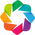

In [7]:
import holoviews as hv
hv.extension('bokeh')

In [8]:
viz = visualize.visualize(ds, Palma, Gibraltar, route_df, filename='route1')
viz.return_plot()

:DynamicMap   [time]
   :Overlay
      .WMTS.I        :WMTS   [Longitude,Latitude]
      .Image.I       :Image   [lon,lat]   (tws)
      .VectorField.I :VectorField   [lon,lat]   (twd_rad,tws)
      .Points.I      :Points   [lon,lat]
      .Points.II     :Points   [lon,lat]
      .Path.I        :Path   [Longitude,Latitude]
      .Points.III    :Points   [lon,lat]   (TWS,TWD,TWA,Boat Speed)

In [9]:
viz = visualize.visualize(ds, Palma, Gibraltar, route_df, filename='route1')
plot = viz.make_plot()
display(plot)

:DynamicMap   [time]
   :Overlay
      .WMTS.I        :WMTS   [Longitude,Latitude]
      .Image.I       :Image   [lon,lat]   (tws)
      .VectorField.I :VectorField   [lon,lat]   (twd_rad,tws)
      .Points.I      :Points   [lon,lat]
      .Points.II     :Points   [lon,lat]
      .Path.I        :Path   [Longitude,Latitude]
      .Points.III    :Points   [lon,lat]   (TWS,TWD,TWA,Boat Speed)

In [ ]:
initial_route = weatherrouter.get_fastest_route(stats=False)
initial_isochrones = weatherrouter.get_isochrones()

optimized_route = weatherrouter.optimize(initial_route, initial_isochrones)
